## Imports

In [1]:
try:
    from pathlib import Path
    import pandas as pd
    import matplotlib.pyplot as plt
    from lib.lib_utils import Utils
    import seaborn as sns
    from lib.lib_defect_analysis import Features
    from tqdm import tqdm

except Exception as e:
    print(f"Some module are missing: {e}\n")

data_path = Path().resolve().joinpath("data")
xyz_files_path = data_path.joinpath("xyz_files")
yolo_model_path = data_path.joinpath("models", "best_100_campioni_new.pt")
images_path = data_path.joinpath("images")
crops_path = data_path.joinpath("crops")

plt.style.use("Solarize_Light2")

## Generate images from xyz files

In [2]:
Utils.from_xyz_to_png(xyz_files_path, images_path)

## YOLO inference to generate binary crops

In [3]:
Utils.generate_yolo_crops(
    images_path,
    crops_path,
    yolo_model_path,
    binary_mask=True,
    device="cpu"
)

## Features extraction and dataframe generation

In [4]:
images = [
    f for f in crops_path.iterdir() if f.suffix.lower() in Features.IMAGE_EXTENSIONS
]

features = {}

for image in tqdm(images):
    if len(features) == 0:
        keys_list = list(features.keys())
        df = pd.DataFrame(columns=keys_list)
    else:
        features.clear()

    name = image.stem.split("_crop")[0]

    with open(str(xyz_files_path.joinpath(f"{name}.xyz")), "r") as file:
        first_line = file.readline()
    n_atoms = int(first_line.strip())

    features.update({"file_name": name})
    features.update({"n_atoms": n_atoms})

    shape_features = Features.extract_shape_features(image, grayscale=True)
    if shape_features is not None:
        features.update(shape_features)

    edge_features = Features.extract_edge_features(image, grayscale=True)
    if edge_features is not None:
        features.update(edge_features)
        
    texture_features = Features.extract_texture_features(image)
    if texture_features is not None:
        features.update(texture_features)

    new_row = pd.Series(features)
    df = pd.concat([df, new_row.to_frame().T], ignore_index=True)

grouped_df = (
    df.groupby("file_name")
    .agg(
        {
            "n_atoms": "first",
            "area": "sum",
            "num_pixels": "sum",
            "perimeter": "sum",
            "circularity": lambda x: (x * df.loc[x.index, "area"]).sum()
            / df.loc[x.index, "area"].sum(),
            "solidity": lambda x: (x * df.loc[x.index, "area"]).sum()
            / df.loc[x.index, "area"].sum(),
            "compactness": lambda x: (x * df.loc[x.index, "area"]).sum()
            / df.loc[x.index, "area"].sum(),
            "feret_diameter": lambda x: (x * df.loc[x.index, "area"]).sum()
            / df.loc[x.index, "area"].sum(),
            "eccentricity": lambda x: (x * df.loc[x.index, "area"]).sum()
            / df.loc[x.index, "area"].sum(),
            "number_of_edges": lambda x: (x * df.loc[x.index, "area"]).sum()
            / df.loc[x.index, "area"].sum(),
            "edge_density": lambda x: (x * df.loc[x.index, "area"]).sum()
            / df.loc[x.index, "area"].sum(),
            "edge_density": lambda x: (x * df.loc[x.index, "area"]).sum()
            / df.loc[x.index, "area"].sum(),
            "GLCM_contrast": lambda x: (x * df.loc[x.index, "area"]).sum()
            / df.loc[x.index, "area"].sum(),
            "GLCM_homogeneity": lambda x: (x * df.loc[x.index, "area"]).sum()
            / df.loc[x.index, "area"].sum(),
            "GLCM_energy": lambda x: (x * df.loc[x.index, "area"]).sum()
            / df.loc[x.index, "area"].sum(),
            "GLCM_correlation": lambda x: (x * df.loc[x.index, "area"]).sum()
            / df.loc[x.index, "area"].sum(),
        }
    )
    .reset_index()
)


original_df = pd.read_csv(xyz_files_path.joinpath("dataset_graphene.csv"))

energy_dict = original_df.set_index("file_name")["total_energy"].to_dict()

# Aggiunta della colonna total_energy al primo dataframe
grouped_df["total_energy"] = grouped_df["file_name"].map(energy_dict)
grouped_df["energy_per_atom"] = grouped_df["total_energy"] / grouped_df["n_atoms"]

grouped_df.to_csv(data_path.joinpath("features.csv"), index=False)

  1%|          | 43/7038 [00:00<00:16, 423.44it/s]

100%|██████████| 7038/7038 [00:17<00:00, 405.87it/s]


## Plot correlations

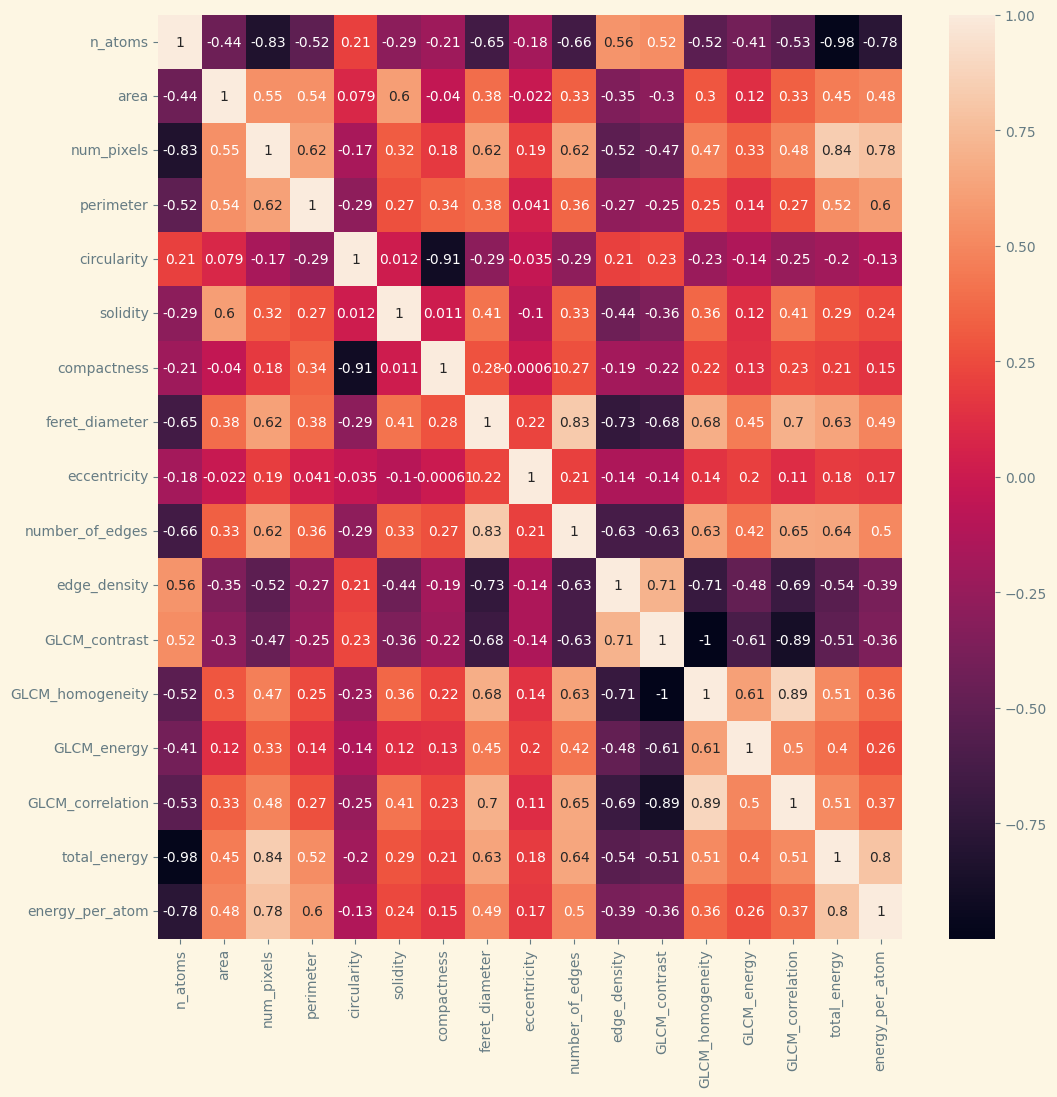

In [7]:
grouped_df = pd.read_csv(data_path.joinpath("features.csv"))
grouped_df = grouped_df.drop(grouped_df[grouped_df["total_energy"] > -2500].index)

columns_to_drop = ["file_name"]
merged_df = grouped_df.drop(columns_to_drop, axis=1)

# stampo heatmap
corr = merged_df.corr(method="kendall")
target_correlation = corr[["total_energy", "energy_per_atom"]]

fig = plt.figure(figsize=(12,12))
sns.heatmap(corr, annot=True)

# stampo basic correlogram
# sns.pairplot(merged_df)
plt.show()

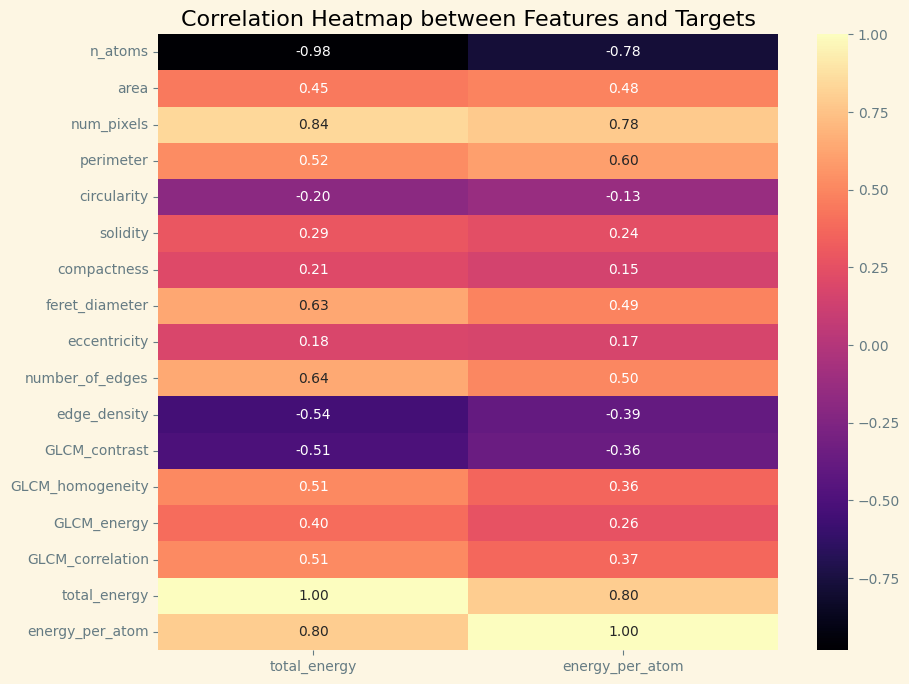

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(target_correlation, annot=True, cmap="magma", fmt=".2f")
plt.title("Correlation Heatmap between Features and Targets")
plt.show()

In [9]:
# g = sns.PairGrid(grouped_df)
# g.map_diag(sns.kdeplot)
# g.map_lower(sns.kdeplot)
# g.map_upper(sns.scatterplot)

## Total energy prediction

In [10]:
try:
    import matplotlib.pyplot as plt
    import numpy as np
    from sklearn import ensemble
    from sklearn.inspection import permutation_importance
    from sklearn.metrics import mean_squared_error
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import MinMaxScaler
    import scipy

except Exception as e:
    print(f"Some module are missing: {e}\n")

## Data preparation

In [15]:
# features_list = [ "area","perimeter", "circularity", "solidity", "compactness", "feret_diameter", "eccentricity", "number_of_edges", "edge_density", "mean_length_of_edges", "std_length_of_edges"]
features_list = [
    "area",
    "perimeter",
    "circularity",
    "solidity",
    "compactness",
    "feret_diameter",
    "eccentricity",
    "number_of_edges",
    "edge_density",
    "GLCM_contrast",
    "GLCM_homogeneity",
    "GLCM_energy",
    "GLCM_correlation",
]

X = grouped_df[features_list].values

y = grouped_df[
    "energy_per_atom"
].values.flatten()  # array con tutti i valori raget total_energy

scaler = MinMaxScaler()
X_norm = scaler.fit_transform(X)

scaler2 = MinMaxScaler()
y_norm = scaler2.fit_transform(y.reshape(-1, 1))

## Split dataset and set hyperparameters

In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    X_norm, y_norm, test_size=0.1, random_state=13
)

XGBOOST senza k-fold


In [17]:
import xgboost as xgb
# Selezione delle quattro feature con maggiore importanza
# params = {
#     "n_estimators": 1500,
#     "min_samples_split": 5,
#     "learning_rate": 0.1,
#     #"loss": "absolute_error",
# }

# params = {"learning_rate": 0.06527271184152461,
#           "n_estimators":830,
#     "max_depth": 6,
#     "min_samples_split": 9,
#     "min_samples_leaf": 10}
# params = {
#     "n_estimators": 1479,
#     "learning_rate": 0.05664451707023027,
#     "max_depth": 7,
#     "gamma" : 3,
#     "min_child_weight":1.3,
#     "colsample_bytree":0.89,
#     "subsample":0.8
#     # "min_samples_split": 11,
#     # "min_samples_leaf": 10,
# }
# params = {'n_estimators': 1628, 'learning_rate': 0.03843617646475424, 'max_depth': 6}
params = {
    "n_estimators": 1850,
    "learning_rate": 0.025250129884021043,
    "max_depth": 9,
    "gamma": 0.000731247172308212,
    "min_child_weight": 8.408269160115502,
    "colsample_bytree": 0.9702313623914688,
    "subsample": 0.5094062459445882,
}
# #model = ensemble.GradientBoostingRegressor(**params)
model = xgb.XGBRegressor(**params)
model.fit(X_train, y_train.ravel())

y_pred = model.predict(X_test)

In [18]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Calcola l'errore quadratico medio
mse = mean_squared_error(y_test, y_pred)

# Calcola l'errore assoluto medio
mae = mean_absolute_error(y_test, y_pred)

# Calcola il coefficiente di determinazione (R-squared)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared:", r2)

Mean Squared Error (MSE): 0.003198037929107239
Mean Absolute Error (MAE): 0.03758760929989456
R-squared: 0.9001692794923208


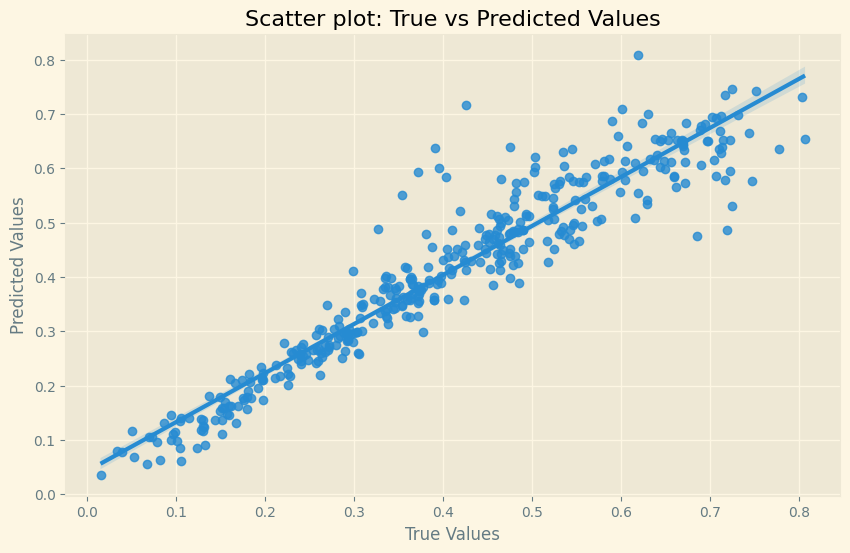

In [19]:
plt.figure(figsize=(10, 6))
sns.regplot(x=np.ravel(y_test), y=np.ravel(y_pred))
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Scatter plot: True vs Predicted Values", color="black")
plt.show()

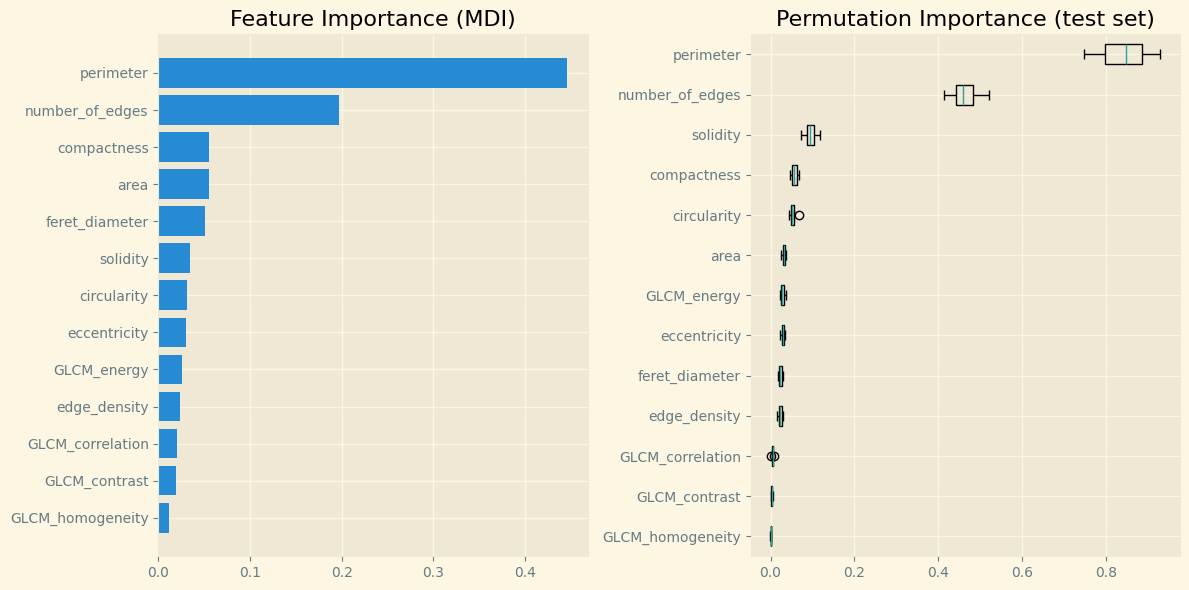

In [20]:
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, np.array(features_list)[sorted_idx])
plt.title("Feature Importance (MDI)")

result = permutation_importance(
    model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=np.array(features_list)[sorted_idx],
)
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()

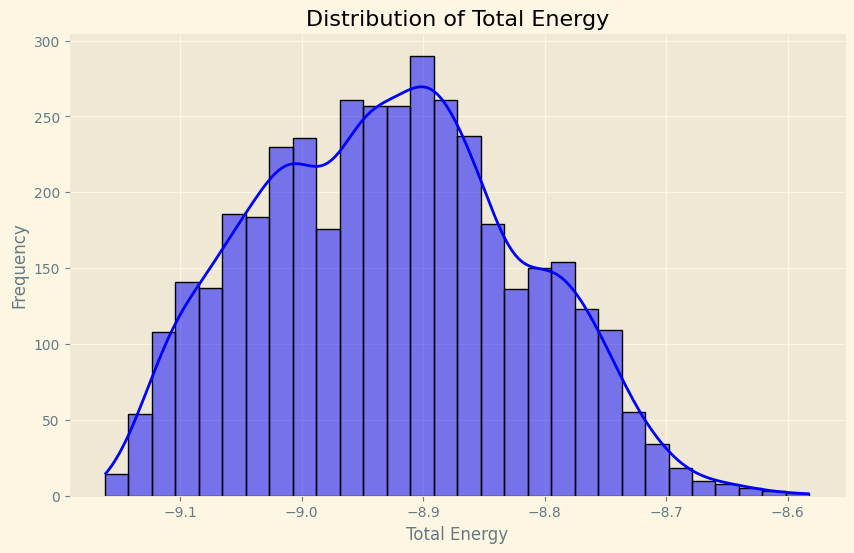

In [21]:
# Plot della distribuzione della variabile target total_energy
plt.figure(figsize=(10, 6))
sns.histplot(y, kde=True, color="blue")
plt.xlabel("Total Energy")
plt.ylabel("Frequency")
plt.title("Distribution of Total Energy")
plt.show()

## Set regressor and loss function

## TEST K FOLD
qui con k fold implementato


MEAN R2 scores 0.9155869807006413 with Gradient Boost: 


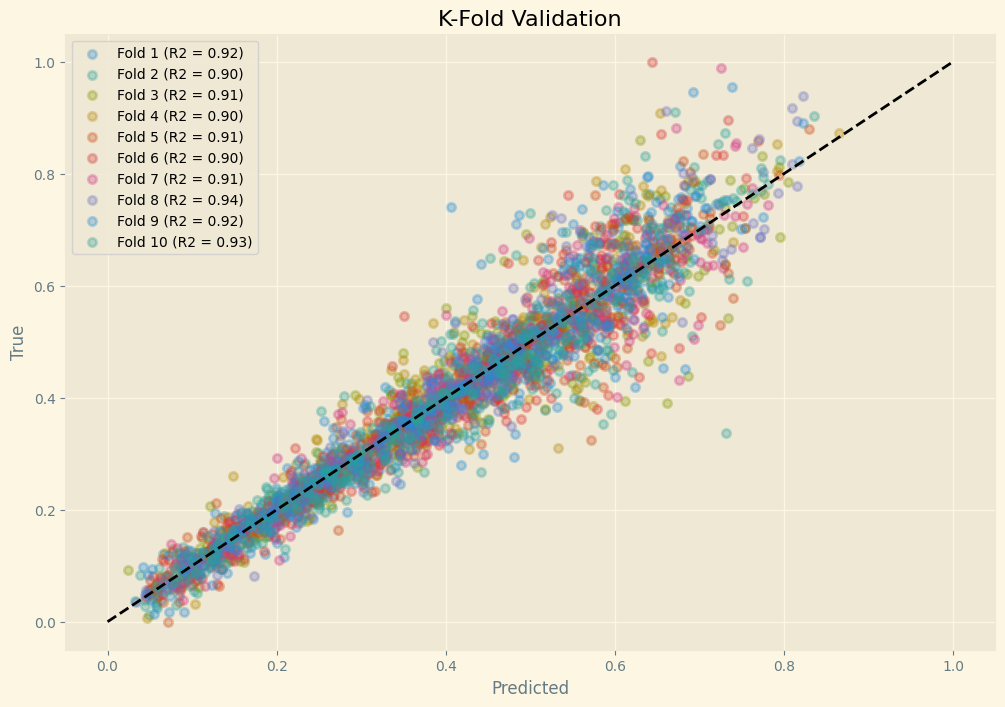

In [22]:
from sklearn import model_selection, metrics
from statistics import mean
import xgboost as xgb
import matplotlib.pyplot as plt

# Definizione dei parametri e inizializzazione del modello
params = {
    "n_estimators": 1850,
    "learning_rate": 0.025250129884021043,
    "max_depth": 9,
    "gamma": 0.000731247172308212,
    "min_child_weight": 8.408269160115502,
    "colsample_bytree": 0.9702313623914688,
    "subsample": 0.5094062459445882,
}

model_boost = xgb.XGBRegressor(**params)

# Preparazione dei dati
y_train = y_train.ravel()
cv = model_selection.KFold(n_splits=10, random_state=1, shuffle=True)

# Creazione della figura e dell'asse
fig, ax = plt.subplots(figsize=(12, 8))

# Ciclo sui fold di cross-validation
scores = []
for i, (train, test) in enumerate(cv.split(X_train, y_train), start=1):
    prediction = model_boost.fit(X_train[train], y_train[train]).predict(X_train[test])
    true = y_train[test]
    score = metrics.r2_score(true, prediction)
    scores.append(score)
    ax.scatter(
        prediction, true, lw=2, alpha=0.3, label="Fold %d (R2 = %0.2f)" % (i, score)
    )

# Tracciamento della linea di riferimento
ax.plot(
    [min(y_train), max(y_train)],
    [min(y_train), max(y_train)],
    linestyle="--",
    lw=2,
    color="black",
)

# Calcolo e stampa della media dei punteggi R2
mean_r2 = mean(scores)
print("MEAN R2 scores {} with Gradient Boost: ".format(mean_r2))

# Impostazione degli elementi del grafico
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_title("K-Fold Validation", color="black")
ax.legend()

# Impostazione del colore del testo della legenda
for text in ax.get_legend().get_texts():
    text.set_color("black")

# Mostra il grafico
plt.show()